# Notebook Setup

First, a few things to setup this notebook.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import requests # web stuff

# Tobacco Shop Analysis

The first dataset I am analyzing is a list of tobacco shops in Allegheny County.

The data set is available [here](https://data.wprdc.org/dataset/allegheny-county-tobacco-vendors).

First, the dataset needs to be prepared.

In [2]:
# read in data
tobacco_data = pd.read_csv("tobacco-data.csv")

# Uh oh, the data is a mess! We need to do some cleanup...
# It turns out our data has a *lot* of extraneous spaces
# So, we can apply a lambda to every data piece to trim whitespace (if it's a string - not all entries are!)
# Not ideal, but it'll do!
tobacco_data = tobacco_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# filter out non pittsburgh entries
# data set uses "PITTSBURGH" and "PGH" - #consistency
tobacco_data = tobacco_data[tobacco_data.apply(lambda row: True if (row.City == "PITTSBURGH") or (row.City == "PGH") else False,axis=1)]

## A problem is encountered...
Unfortunately, this data set has a **major** problem! There is *no* data on *what* neighborhood the store lies in!

This is going to require the integration of some other data sets. One link we can make use of is Parcel IDs.
So, we're going to use [this property asssessment data set](https://data.wprdc.org/dataset/property-assessments).

It turns out this data set is *huge*, so some cleanup is needed.
This process can be seen in the **'patrick-data-cleanup'** notebook.

In [3]:
parcel_mappings = { }
for index, row in pd.read_csv("clean_assessments.csv").iterrows():
    parcel_mappings[str(row['PROPERTYHOUSENUM']) + " " + row['PROPERTYADDRESS']] = row['PARID']

## Finding a Link

Now, we're going to create a list our valid Parcel IDs.
We will use this list later to map to addresses.

In [10]:
def clean_street(street):
    return street.replace("AVENUE", "AVE", 1).replace("STREET", "ST", 1).replace("BOULEVARD", "BLVD", 1).replace("HIGHWAY", "HWY", 1)

# loop over each entry of zip/number of occurrences
parcel_ids = [ ]
for index, row in tobacco_data.iterrows():
    # First, we need to convert the zip code to a neighborhood
    street = row['Street1']
    street = clean_street(street)
    if street in parcel_mappings:
        parcel_ids.append(parcel_mappings[street])
    else: # use backup street 2
        street = row['Street2']
        if street: # string is not empty
            street = clean_street(street)
            if street in parcel_mappings:
                parcel_ids.append(parcel_mappings[street])

## Getting Our Neighborhoods
Lucky for us, the WPRDC provides a property API that allows us to obtain a *lot* of information from a Parcel ID.
It just so happens that this information often includes a neighborhood!

The API can be found at: https://tools.wprdc.org/property-api/

In [6]:
import requests

In [7]:
# first, we need to make our request strings
# basically, this is just a comma separted list of Parcel IDs
# of course, we can't nuke the api with hundreds of API requests at once!
request_strings = [ ]

current_request = "" # comma separted list of 10 Parcel IDs
current_index = 1
for parcel_id in parcel_ids:
    current_request = current_request + parcel_id + ","
    current_index += 1
    if current_index == 10:
        current_request = current_request[:-1] # trim off extraneous comma
        request_strings.append(current_request) # add to completed list
        current_request = "" # reset current request back to default state
        current_index = 1 # reset counter back to default state

In [14]:
# now, let's make our web requests and count those neighborhoods
neighborhood_counts = { }

for request_string in request_strings:
    result = requests.get(url = "https://tools.wprdc.org/property-api/v0/parcels/" + request_string)
    json = result.json()
    for result in json["results"]:
        try:
            neighborhood = result["data"]["centroids_and_geo_info"][0]["geo_name_nhood"] # work through json to neighborhood
        except:
            # guess that one didn't work!
            continue
        if neighborhood == None: # a shame!
            continue
        if neighborhood in neighborhood_counts:
            neighborhood_counts[neighborhood] += 1
        else:
            neighborhood_counts[neighborhood] = 1

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 61 Text major ticklabel objects>)

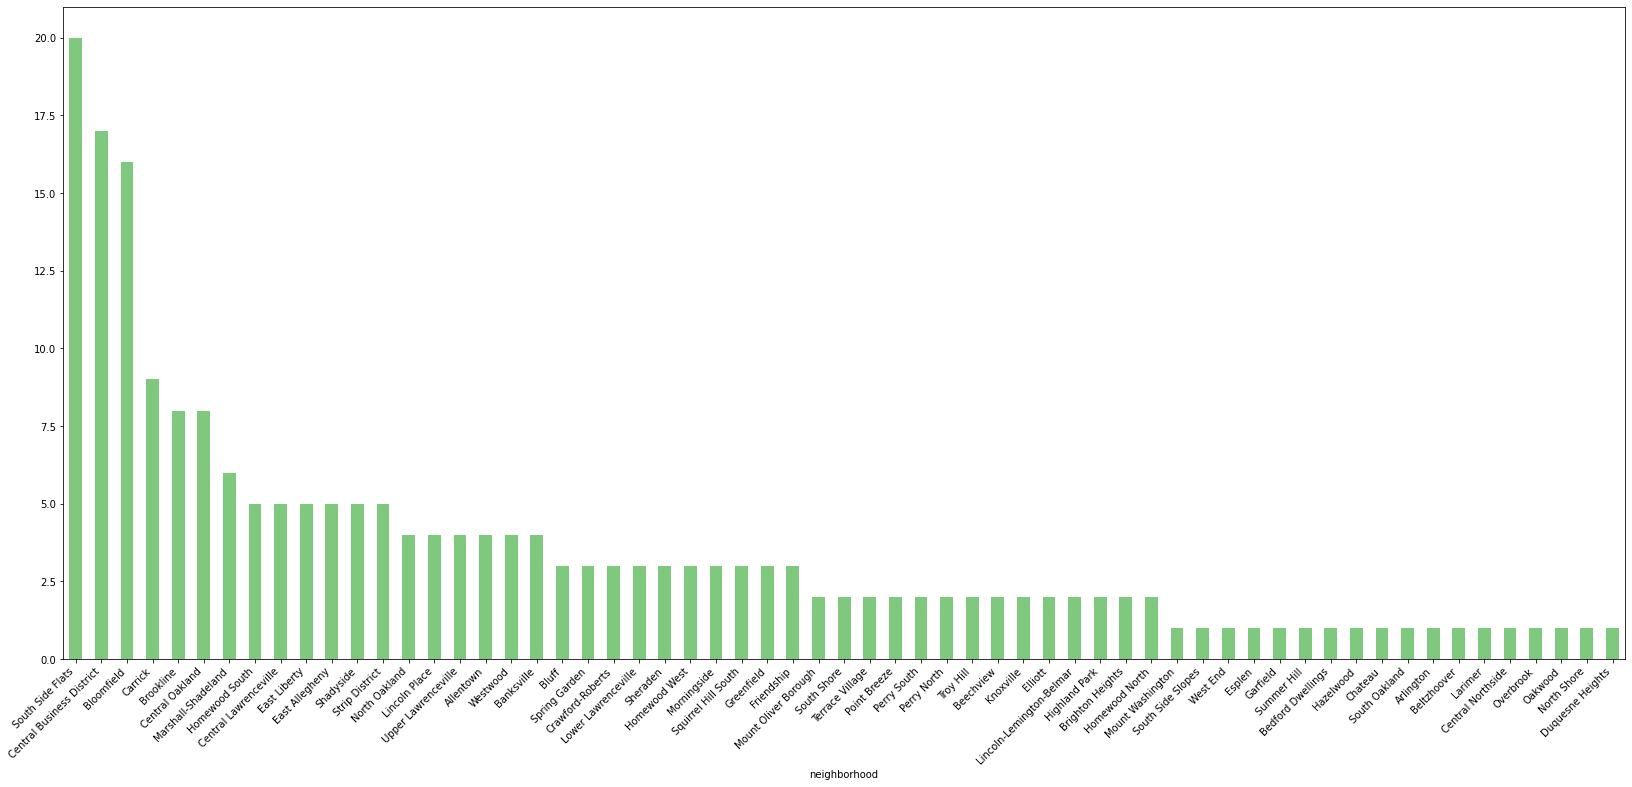

In [9]:
df = pd.DataFrame(neighborhood_counts.items(), columns=["neighborhood", "num_tobacco_shops"])
df.groupby("neighborhood").sum()["num_tobacco_shops"].sort_values(ascending=False).plot.bar(colormap='Accent', figsize=(28, 12))
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium',
)

# Conclusion

We can conclude, based on the bar graph above, that South Side Flats would be the best neighborhood based on the number of tobacco shops.